# Random Forest Model

## Importing Libraries

In [1]:
import requests, json, time, re
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('../data/df_combined.csv',index_col='Unnamed: 0')
df.head(2)

,author,author_fullname,subreddit_suicidewatch,id,created_utc,retrieved_on,permalink,url,num_comments,title,selftext,selftext_char_cnt,selftext_word_count
0,gothic_reality,t2_39c20e2f,0,b7vfje,1554081327,1554081328,/r/depression/comments/b7vfje/how_do_i_explain...,https://www.reddit.com/r/depression/comments/b...,0,How do i explain to my mom that liking dark st...,"I love my mom, but sometimes she overreacts to...",391,80
1,3453456346346,t2_335d0qqi,0,b7vf2d,1554081250,1554081251,/r/depression/comments/b7vf2d/i_want_to_lie_do...,https://www.reddit.com/r/depression/comments/b...,0,I want to lie down on a bed and curl up to sle...,I hate doing anything - i hate typing this but...,762,153


## Assigning X and Y Variables

Our y, 'subreddit_suicidewatch' is our response variable that we're trying to correctly classify. The 'selftext' will be the foundation of our predictor variables. We will vectorize this text using the TD-IDF method.

In [3]:
X = df[['selftext']]
y = df['subreddit_suicidewatch']

## Train/Test/Split

Next we'll use `train_test_split` to create a train and test set for our data. We'll train our model on the training data and test our fitted model on the test date to measure our accuracy. By default, we'll fit our model on 75% of the observations (training data) and use the remaining 25% to generate our predictions.

In [4]:
np.random.seed(23)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y
                                                   )

## Instantiate TDIDF

TF-IDF stands 'Term Frequency — Inverse Data Frequency'. It provides both a measure for how often a word is present in a given document, while taking into account how often the word appears across the entire corpus of documents.

The 'TF' stands for 'Term Frequency' and is the ratio of number of times the word appears in a document relative to the total number of words in that document. If the word appears more frequently, the value will increase

The 'IDF' stands for Inverse Document Frequency, it applies a weight corresponding to how often a word occurs across all documents. For instance, words that are present in many documents will have a lower IDF value, while words that are more rare will have a higher IDF value.

In [5]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=.95)

In [6]:
train_raw = tfidf.fit_transform(X_train['selftext'])

### Creating a Sparse Matrix

We'll convert the tfidf matrix to a sparse data frame. Sparse data frames contain mostly zeros. Stored apprpriate data in a sparse matrix allow the matrix to be stored more efficiently, and typically speed up machine learning processes

In [7]:
train_df = pd.SparseDataFrame(train_raw, columns=tfidf.get_feature_names())
train_df.head()

,00,000,00am,01,03,10,100,1000,100k,100mg,...,yup,zaps,zealand,zen,zero,zoloft,zombie,zone,zoned,zoning
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fill NAs

In [8]:
train_df.fillna(0, inplace=True)

In [9]:
train_df.head()

,00,000,00am,01,03,10,100,1000,100k,100mg,...,yup,zaps,zealand,zen,zero,zoloft,zombie,zone,zoned,zoning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Replicate the Process for X-test

In [10]:
test_df = pd.SparseDataFrame(tfidf.transform(X_test['selftext']), columns=tfidf.get_feature_names())
test_df.fillna(0, inplace=True)

In [11]:
test_df.head()

,00,000,00am,01,03,10,100,1000,100k,100mg,...,yup,zaps,zealand,zen,zero,zoloft,zombie,zone,zoned,zoning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Instantiate and Fit Random Forest Model

### Random Forest Overview

Random Forest is a decision tree modeling technique that seeks to overcome some of the disadvantages of standard decision trees. Decision trees are a non-parametric modeling technique that make sequential, hierarchical decisions on features in order to predict an outcome variable (i.e. Logical IF statements). They can be utilized in the regression and classification setting.

Generally, the advantages of decision trees are that they're somewhat interpretable/explainable, they train/predict quickly, and there is little data prep needed (no scaling, no dummying, etc.). Among the disadvantages are that a single tree tends to be overfit to the data it was trained on.

Random Forest attempts to address this issue in two main ways:
1. We take many samples of the training data using a method called bootstraping. With bootstraping, we draw samples from the training data with replacement. We fit a decision trees on each one of these sample.

2. In addition to bootstraping, each internal node of the fitted trees is only exposed to a subset of the total features (generally sqrt(p features)). This is done to ensure that individual trees are not highly correlated with each other by folowing a similar decision path.

Splits are decided based on the 'purity' gain at each split. Purity refers to the proportion of observations in the leaf/terminal node that belong to the same class. If all the observations in the node belong to the same class the node is 100% pure.

## Hyperparameter Tuning Using RandomizedSearchCV()

RandomizedSearchCV is a method for finding the optimal hyperparameters for a machine learning algorithm. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions.

[Source](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

**Random Forest Hyperparameters to Test:**
- n_estimators: the number of decision trees
- max_depth: the max number of decion ndes. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- min_samples_split: the minimum number of samples required to split an internal node
- min_samples_leaf: the minimum number of samples required to be at a leaf node

[Source](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Create the parameter grid from which hyperparameters are sampled. Based on trial and error, we observed the highest test accuracy with the lowest prevalence of overfitting with the below values. N_estimators = 100, max_depth = 60, and min_samples_leaf = 10.

We are hard coding these hyperparameter values and sampling from a distribution of min_sample_split values between 10 and 50. By default, `RandomizedSearchCV` will sample from the parameter grid 10 times.

In [13]:
# Adapted from:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

random_grid = {'n_estimators': [100],
               'max_depth': [60],
               'min_samples_split': [int(x) for x in np.linspace(10, 80,10)],
               'min_samples_leaf': [10]
               }

### Instantiate and Fit the Model

In addition to using `RandomizedSearchCV()` to tune hpyerparameters, we'll also use 3-fold cross-validation to fit our hyperparameter combnations to 3 different samples of the training data.

In [14]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               return_train_score=True,
                               n_jobs = -1)

rf_random.fit(train_df, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 75.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100], 'max_depth': [60], 'min_samples_split': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'min_samples_leaf': [10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

Below we can see the best parameters from our fitted model, best on the highest mean accuracy score across the 3 folds.

In [15]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 64,
 'min_samples_leaf': 10,
 'max_depth': 60}

We see that given a min_samples_leaf ranging from 10-80, the model selected 45, on the higher end of the range.

Calculating our train/test accuracy scores:

In [16]:
rf_random.score(train_df, y_train)

0.8260164997053624

In [17]:
rf_random.score(test_df, y_test)

0.7118868758285462

We can see our accuracy on the training data is 83% and the accuracy on the test data is 71%. Previous Random Forest iterations had a much higher training score (95-99%), with around the same test score. This model is less overfit, and will likely generalize better to unseen data.

Below we can plot that mean test accuracy score for each 'min_samples_split' that was test

''

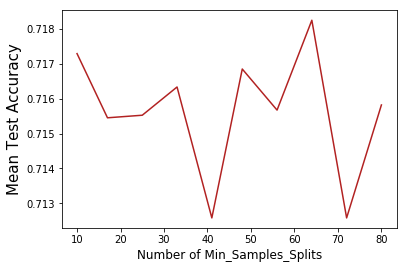

In [68]:
tested_min_samples_split = [x['min_samples_split'] for x in rf_random.cv_results_['params']]
rf_random.cv_results_['mean_test_score']
plt.plot(tested_min_samples_split, rf_random.cv_results_['mean_test_score'], color = 'firebrick')
plt.xlabel('Number of Min_Samples_Splits', fontsize=12)
plt.ylabel('Mean Test Accuracy', fontsize=15);
;

We see that our accuracy peaked at mss=10, and mss=60.

### Analyzing the Confusion Matrix

The confusion matrix is a simple visual representation of our how our predictions in each class correspond to the actual classification.

In [30]:
from sklearn.metrics import confusion_matrix
predictions = rf_random.predict(test_df)
confusion_matrix(y_test, predictions)

array([[1593,  666],
       [ 638, 1629]])

The confusion matrix can be interpreted as follows:
- **True Negative** (top left): observations we correctly identified as the negative class, which in this case refers to the depression subreddit (1593)
- **False Positive** (top right): observations we incorrectly identified as the positive class, meaning we predicted it from the suicidewatch subreddit but it was from depression (666)
- **False Negative** (bottom left): observations we incorrectly identified as the negative class, meaning we predicted it was from the depression subreddit but it was from suicidewatch (638)
- **True Positive** (bottom right): observations we correctly identified as the positive class, which in this case refers to the suicidewatch subreddit (1629)

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

### Confusion Matrix Summary

In [32]:
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Sensitivty: {tp/(tp+fn)}")
print(f"Specificty: {tn/(tn+fp)}")
print(f"Accuracy: {(tp+tn)/((tp+ tn+fp+fn))}")

True Negatives: 1593
False Positives: 666
False Negatives: 638
True Positives: 1629
Sensitivty: 0.7185707984119982
Specificty: 0.7051792828685259
Accuracy: 0.7118868758285462


Of the suicidewatch subreddit posts, we identified 72% of them accurately. This is denoted by the Sensitivity metric in the table above. Of the depression subreddit posts, we corectly identified 71% of them. 

Unlike our Naive Bayes model where our model was clearly more effective at identifying Suicidewatch submissions (Sensitivity-66%, Specificity-51%) the random forest predictions are on par for both classes.

### Visualizing the Predicted Probabilities

Below we can visualize the predicted probabilities in the histogram

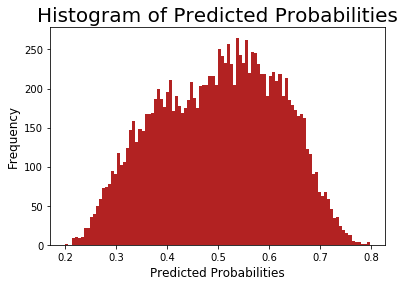

In [67]:
rf_random_predprobs = rf_random.predict_proba(train_df)[:,1]

plt.hist(rf_random_predprobs, bins=100, color= 'firebrick');
plt.xlabel('Predicted Probabilities', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Histogram of Predicted Probabilities', fontsize=20);

In [42]:
print(f'Max Predicted Proba is: {np.max(rf_random_predprobs)}')
print(f'Min Predicted Proba is: {np.min(rf_random_predprobs)}')
print(f'Median Predicted Proba is: {np.median(rf_random_predprobs)}')
print(f'Mean Predicted Proba is: {np.mean(rf_random_predprobs)}')

Max Predicted Proba is: 0.7966748233809297
Min Predicted Proba is: 0.20055436624214845
Median Predicted Proba is: 0.5082677683190719
Mean Predicted Proba is: 0.5002923723951301


What we notice here is that while our overall accuracy is okay at 71%, we are not overly confident in any of the predictions, frankly. No predicted probabilities is greater than 80% and none are less than 20%.

### Top Features based on Importance

The feature importance is a measure for how much each feature contributes to decreasing the weighted impurity (on avg. across all the tress)

In [57]:
features = tfidf.get_feature_names()
importance = rf_random.best_estimator_.feature_importances_

In [58]:
rf_feature_weights = pd.DataFrame({'features':features, 'importance': importance})

In [ ]:
rf_feature_weights.set_index('features',inplace=True)

Plotting the top 20 features below:

In [64]:
rf_top20 = rf_feature_weights.sort_values('importance', ascending=False)['importance'].head(20)
rf_labels_top20 = rf_top20.index

''

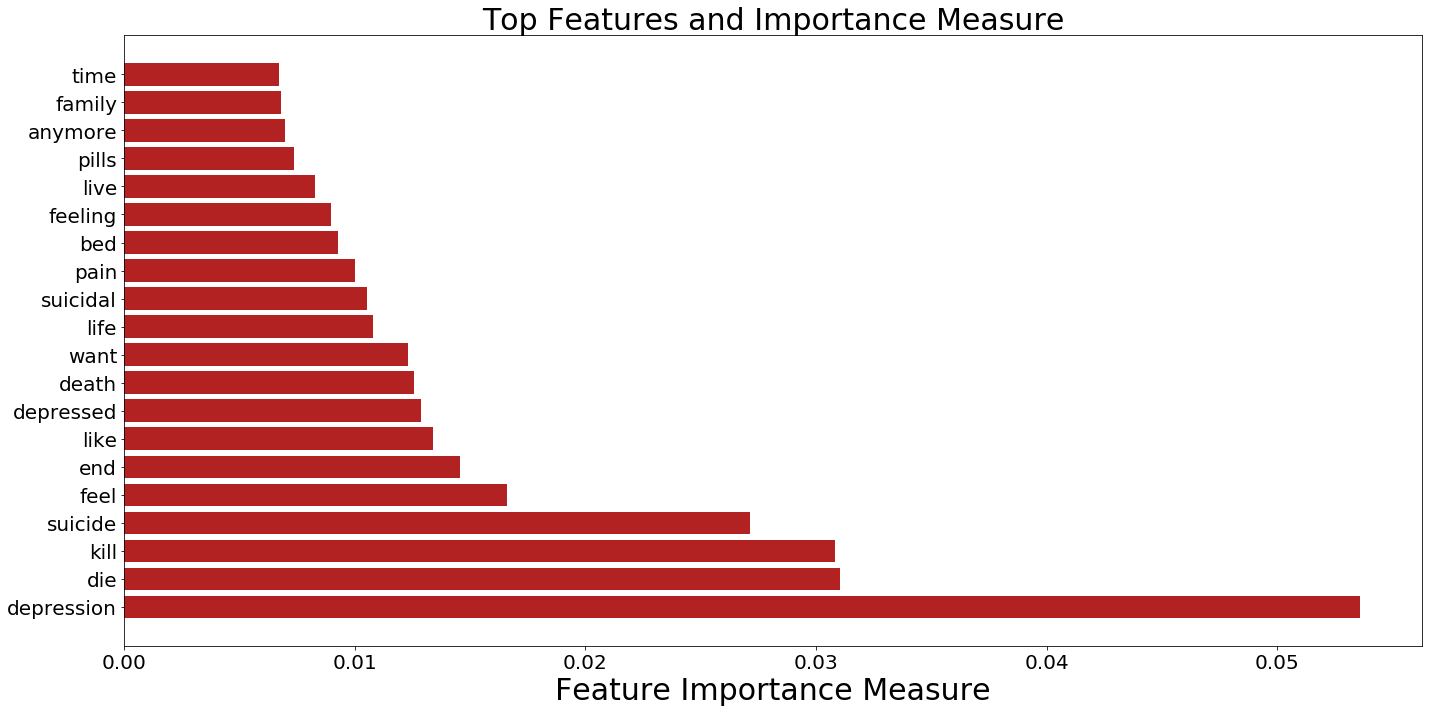

In [66]:
plt.figure(figsize=(20,10))
plt.barh(rf_labels_top20, rf_top20, color= 'firebrick')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Importance Measure', fontsize=30)
# plt.ylabel('Feature', fontsize=30)
plt.title(f'Top Features and Importance Measure', fontsize=30)
plt.tight_layout()

# Saving the image
# plt.savefig('../images/rf_feat_weights.png')
;

### Saving Model

In [ ]:
# import pickle

# with open('../assets/random_forest/pkl','wb+') as f:
#     pickle.dump(rf_random, f)

### Loading Model

In [ ]:
# import pickle

# with open('../assets/filename/pkl','wb+') as f:
#     pickle.load(rf_random, f)